In [7]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pandas as pd
import matplotlib.gridspec as gridspec
import astropy.units as u
import astropy.constants as c
from specutils import Spectrum1D
from specutils.manipulation import gaussian_smooth
from specutils.manipulation import FluxConservingResampler
import matplotlib.colors as colors
from photutils.aperture import RectangularAperture
font = {'size'   : 12}
plt.rc('font', **font)

In [8]:
def readL3a(path='../input/', 
                file='test_sim67_L3a.fits'):
    
    """
    Read a simulated L3a file
    """
    
    dat = fits.open(path+file)
    lam = pd.DataFrame((dat[2].data)).to_numpy().flatten()
    counts1 = np.sum(np.array(dat[3].data['COUNTS_1']), axis=0)
    counts2 = np.sum(np.array(dat[3].data['COUNTS_2']), axis=0)
    flux1 = np.sum(np.array(dat[3].data['SB_1']), axis=0)
    flux2 = np.sum(np.array(dat[3].data['SB_2']), axis=0)
    
    return lam, counts1, counts2, flux1, flux2


In [9]:
def readL2(path='../input/', 
                file='test_sim67_L2.fits'):
    
    """
    Read a simulated L2 file
    """
    
    dat = fits.open(path+file)
    X = dat[1].data['X']
    Y = dat[1].data['Y']
    return X, Y
    

In [10]:
def readSpecCalFUSE(target='GCRV12336'):
    
    """
    Read FUSE spectrum for spectral calibration target
    """
    
    path = '../input/'
    file = target+'_combined.fit'
    
    dat = fits.open(path+file)[1].data
    lam = dat['WAVE']
    flux = dat['FLUX']
    
    return lam, flux

In [11]:
def lamToX(lam, lam0=1035., dlam=0.148, X0=1200.):
    
    """
    Convert wavelengths (in AA) into detector coordinates
    """
    
    X = (lam-lam0)/dlam + X0
    return X

In [74]:
def FUSEToAspera(lamFUSE, fluxFUSE, texp, specbin=50.*u.km/u.s, aeff=0.75*u.cm**2, 
                noise=True, flux=False):
    
    
    """
    Transform a FUSE spectrum into a simulated Aspera spectrum
    """
    
    # Create Spectrum1D objects
    spec = Spectrum1D(spectral_axis=lamFUSE*u.AA, 
                      flux=fluxFUSE*u.erg/u.s/u.cm**2/u.AA)
    
    # Convolve to R=1500
    std_AA = 1035*u.AA/1500/(2.*np.sqrt(2.*np.log(2)))
    stddev_px = (std_AA/np.mean(np.diff(lamFUSE*u.AA))).decompose().value
    spec_smooth = gaussian_smooth(spec, stddev=stddev_px) 
    
    # Rebin on 50 km/s grid
    dlam_new = ((specbin/c.c)*1035*u.AA).to(u.AA).value
    lam_new = np.arange(lamFUSE[0], lamFUSE[-1], step=dlam_new)*u.AA
    fluxc_resample = FluxConservingResampler(extrapolation_treatment='zero_fill')  
    spec_rebinned = fluxc_resample(spec_smooth, lam_new)
    
    # Compute total flux (ass a cross check)
    flux_old = np.nansum(spec_smooth.flux)*np.diff(spec_smooth.spectral_axis)[0]
    flux_new = np.nansum(spec_rebinned.flux)*np.diff(spec_rebinned.spectral_axis)[0]
    
    # Convert flux density to counts
    energy = c.h*c.c/lam_new 
    dlam = dlam_new*u.AA
    counts = (spec_rebinned.flux/energy*texp*aeff*dlam).decompose()[1:-1]
    
    # If requested, add random Poisson noise
    if noise:
        counts = np.random.poisson(lam=counts)
        
    # If requested, return flux density instead of counts
    if flux == True:
        return lam_new.value[1:-1], spec_rebinned.flux.value[1:-1]
    
    else: 
        return lam_new.value[1:-1], counts 
    

In [75]:
def countsToEnergyDensity(lam, counts, texp):
    
    """
    Convert count spectrum in to energy density (erg/s/AA)
    """
    
    # Determine wavelength bin size
    dlam = np.diff(lam)[0]*u.AA
    
    # Compute photon energy
    energy = counts*c.h*c.c/(lam*u.AA)
    
    # Compute energy density
    energyDensity = (energy / texp / dlam).to(u.erg/u.s/u.AA)
    
    return energyDensity.value

In [76]:
def readSimCube():
    
    """
    Read simulation cube
    """
    
    path = '/Users/kepplerm/Documents/Work/Projects/Aspera/datsim/MHD_LCorlies/'
    file = 'aspera_-1000_1000_10kms.fits'
    dat = fits.open(path+file)[1].data*u.erg/u.s/u.cm**2/u.arcsec**2
    dat *= 23.7305 # scaling factor
    
    return np.sum(dat, axis=2).to(u.erg/u.s/u.cm**2/u.arcsec**2).value

In [77]:
def plotSpectralCalProcess():
    
    #fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    fig = plt.figure(1, figsize=(21,12.5))
    gs = gridspec.GridSpec(3,5, height_ratios=[1,1,1], 
                                width_ratios=[1,1,1,0.01,1]) 
    gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.8, hspace=0.5) 
    fs = 12
    
    # Read data cube
    cube = readSimCube()
    
    # Read event list
    Xout, Yout = readL2()
    
    # Read Aspera spectrum
    lam, counts1, counts2, flux1, flux2 = readL3a()
    X = lamToX(lam)
    
    # Read spectral cal FUSE spectrum
    lamSpec, fluxSpec = readSpecCalFUSE() 
    XSpecFUSE = lamToX(lamSpec)
    
    # Read photometric cal FUSE spectrum
    lamPhot, fluxPhot = readSpecCalFUSE(target='GD246') 
    XPhotFUSE = lamToX(lamPhot)
    
    # Generate simulated spectrum for spectral calibration target
    lamSpecAsp, countsSpecAsp = FUSEToAspera(lamSpec, fluxSpec, 11700*u.s)
    lamSpecAsp_nonoise, countsSpecAsp_nonoise = FUSEToAspera(lamSpec, fluxSpec, 11700*u.s, noise=False)
    XSpecAsp = lamToX(lamSpecAsp)
    
    # Generated simulated spectrum for flux calibration target
    texp_phot = 4600
    lamPhotAsp, countsPhotAsp = FUSEToAspera(lamPhot, fluxPhot, texp_phot*u.s)
    lamPhotAsp, countsPhotAsp_nonoise = FUSEToAspera(lamPhot, fluxPhot, texp_phot*u.s, noise=False)
    lamPhotAsp_nonoise, fluxPhotAsp_nonoise = FUSEToAspera(lamPhot, fluxPhot, texp_phot*u.s, noise=False, flux=True)
    
    # Compute energy density for flux calibration observation
    energyDensityPhot = countsToEnergyDensity(lamPhotAsp, countsPhotAsp, texp_phot*u.s)
    
    # Parameters for plot
    lamlim = np.array((1028, 1036))
    lamlim_ext = np.array((1020, 1050))
    Xlim = lamToX(lamlim)
    Xlim_ext = lamToX(lamlim_ext)
    
    colarr = ['goldenrod', 'indianred', 'darkslateblue', 'black']
    
    # ================================
    # Plot 0: Image cube
    # ================================
    ax0 = plt.subplot(gs[0,1])
    xaxis = (np.arange(cube.shape[0])-int(cube.shape[0]/2))*7.63 # convert to arcsec
    yaxis = (np.arange(cube.shape[1])-int(cube.shape[1]/2))*7.63 # convert to arcsec
    ax0.pcolormesh(xaxis, yaxis, cube.T, norm=colors.LogNorm(vmin=5.e-20, vmax=8.e-17), 
                   cmap='magma')
    aper = RectangularAperture((0,0), 1470, 30, theta=90*u.deg)
    aper.plot(color=colarr[0])
    ax0.set_xlabel(r'$\Delta$RA [arcsec]') 
    ax0.set_ylabel(r'$\Delta$DEC [arcsec]') 
    ax0.tick_params(axis='both', colors='white', which='both', labelcolor='k')
    ax0.set_xlim(-800, 800)
    ax0.set_ylim(-800, 800)
    ax0.set_xticks([-500,0,500])
    ax0.set_yticks([-500,0,500])
    ax0.set_aspect('equal')
    #ax0.text(-720, 650, 'Simulated OVI SB distribution', color='white', fontsize=fs)
    
    # ================================
    # Plot 0.5: Event list
    # ================================
    ax05 = plt.subplot(gs[0,2])
    ax05.scatter(Xout, Yout, s=0.05, alpha=0.3, color='gray')
    ax05.set_xlabel(r'X', ) 
    ax05.set_ylabel(r'Y', ) 
    ax05.text(800, 2900, 'Simulated detector image', fontsize=fs)
    ax05.set_aspect('equal') 
    
    # ================================
    # Plot 1: counts vs X
    # ================================
    ax1 = plt.subplot(gs[0,4])
    ax1.step(X, counts1, where='mid', color='gray')
    ax1.set_xlim(Xlim[0], Xlim[1])
    ax1.set_xlabel('X [px]') 
    ax1.set_ylabel('Counts') 
    ax1.text(1154, 215, 'Extracted spec.', fontsize=fs)
    ax1.text(1154, 200, '(Counts vs. X coord.)', fontsize=fs)
    
    # ================================
    # Plot 2: counts vs lambda
    # ================================
    ax2 = plt.subplot(gs[1,4])
    ax2.step(lam, counts1, where='mid', color='dimgray')
    ax2.set_xlabel(r'$\lambda$ [AA]', color=colarr[1]) 
    ax2.set_ylabel('Counts') 
    ax2.set_xlim(lamlim[0], lamlim[1])
    ax2.text(1028.3, 215, 'Wavelength-calibrated spec.', fontsize=fs)
    ax2.text(1028.3, 200, '(Counts vs. wavelength)', fontsize=fs)
    
    # ================================
    # Plot 3: flux vs lambda
    # ================================
    ax3 = plt.subplot(gs[2,4])
    ax3.step(lam, flux1, where='mid', color='dimgray')
    ax3.set_xlabel(r'$\lambda$ [AA]', color=colarr[1]) 
    ax3.set_ylabel(r'Flux density [erg/s/cm^2/AA]', color=colarr[2]) 
    ax3.set_xlim(lamlim[0], lamlim[1])
    ax3.text(1028.3, 1.42e-18, 'Flux-calibrated spec.', fontsize=fs)
    ax3.text(1028.3, 1.3e-18, '(Flux density vs. wavelength)', fontsize=fs)
    
    # ================================
    # Plot 4: Simulation of spectral cal extraction
    # ================================
    ax4 = plt.subplot(gs[1,2])
    ax4.step(XSpecAsp, countsSpecAsp, where='mid', color=colarr[1])
    # Plot a range of wavelength solutions
    for i in range(0, 10):
        XSpecAsp_sample = lamToX(lamSpecAsp, X0=1200-5+i)
        ax4.step(XSpecAsp_sample, countsSpecAsp_nonoise, where='mid', alpha=1.0, 
                zorder=0, color='gray', lw=0.2)
    ax4.set_xlabel(r'X [px]') 
    ax4.set_ylabel(r'Counts') 
    ax4.set_xlim(Xlim_ext[0], Xlim_ext[1])
    ax4.text(1107, 320, 'Comparison to template spec.', fontsize=fs)
    
    # ================================
    # Plot 5: Simulation of spectral cal observations
    # ================================
    ax5 = plt.subplot(gs[1,1])
    ax5.step(XSpecAsp, countsSpecAsp, where='mid', color=colarr[1])
    ax5.set_xlabel(r'X [px]') 
    ax5.set_ylabel(r'Counts') 
    ax5.set_xlim(Xlim_ext[0], Xlim_ext[1])
    ax5.text(1110, 320, 'Simulated spectral cal. spec.', fontsize=fs)
    
    # ================================
    # Plot 8: Simulation of flux cal observations
    # ================================
    ax8 = plt.subplot(gs[2,0])
    ax8.step(lamPhotAsp, countsPhotAsp, where='mid', color=colarr[2])
    ax8.set_xlabel(r'$\lambda$ [AA]') 
    ax8.set_ylabel(r'Counts') 
    ax8.set_xlim(lamlim_ext[0], lamlim_ext[1])
    ax8.text(1021.5, 273, 'Simulated flux cal. spec.', fontsize=fs)
    
    # ================================
    # Plot 7: Plot of energy density and flux density (Aspera / FUSE)
    # ================================
    ax7 = plt.subplot(gs[2,1])
    ax72 = ax7.twinx()
    ax7.step(lamPhotAsp, energyDensityPhot, where='mid', color=colarr[2], alpha=0.5, label='Simulated obs.')
    ax72.step(lamPhotAsp, fluxPhotAsp_nonoise, where='mid', color=colarr[3], label='Template spectrum')
    ax7.tick_params(axis='y', colors=colarr[2])
    ax72.tick_params(axis='y', colors=colarr[3])
    ax7.set_xlabel(r'$\lambda$ [AA]') 
    ax7.set_ylabel(r'Energy density [erg/s/AA]', color=colarr[2]) 
    ax72.set_ylabel(r'Flux density [erg/s/AA/cm$^2$]', color=colarr[3])
    ax7.set_xlim(lamlim_ext[0], lamlim_ext[1])
    ax72.set_ylim(0., 10.7e-12)
    ax7.set_ylim(0., 8e-12)
    ax7.legend(bbox_to_anchor=(0.23,0.33))#,loc='center right')
    ax72.legend(loc='lower right')
    ax7.text(1021.3, 7.3e-12, 'Comparison to template spec.', fontsize=fs)
    
    # ================================
    # Plot 7: Plot of effective area
    # ================================
    ax6 = plt.subplot(gs[2,2])
    aeff = energyDensityPhot / fluxPhotAsp_nonoise
    ax6.step(lamPhotAsp, aeff, where='mid', color=colarr[2], alpha=0.5)
    ax6.axhline(0.75, color='k', ls=':')
    ax6.set_xlabel(r'$\lambda$ [AA]') 
    ax6.set_ylabel(r'Effective area [cm$^2$]') 
    ax6.set_xlim(lamlim_ext[0], lamlim_ext[1])
    ax6.set_ylim(0,1.5)
    ax6.text(1021.5, 1.35, 'Fit to effective area curve', fontsize=fs)
    
    
    # Adjust axes
    ax_arr = [ax0, ax05, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    [ax.minorticks_on() for ax in ax_arr]
    [ax.tick_params(axis="both",direction="in", which='both', right=True, top=True) for ax in ax_arr]
    
    plt.tight_layout()
    plt.savefig('calibration_flow.png', dpi=100)
    plt.show()

/var/folders/5d/x80kzfgn4_d39q7l1tv4s1600000gn/T/ipykernel_98922/1593554026.py:171: RuntimeWarning: invalid value encountered in divide
  aeff = energyDensityPhot / fluxPhotAsp_nonoise
/var/folders/5d/x80kzfgn4_d39q7l1tv4s1600000gn/T/ipykernel_98922/1593554026.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


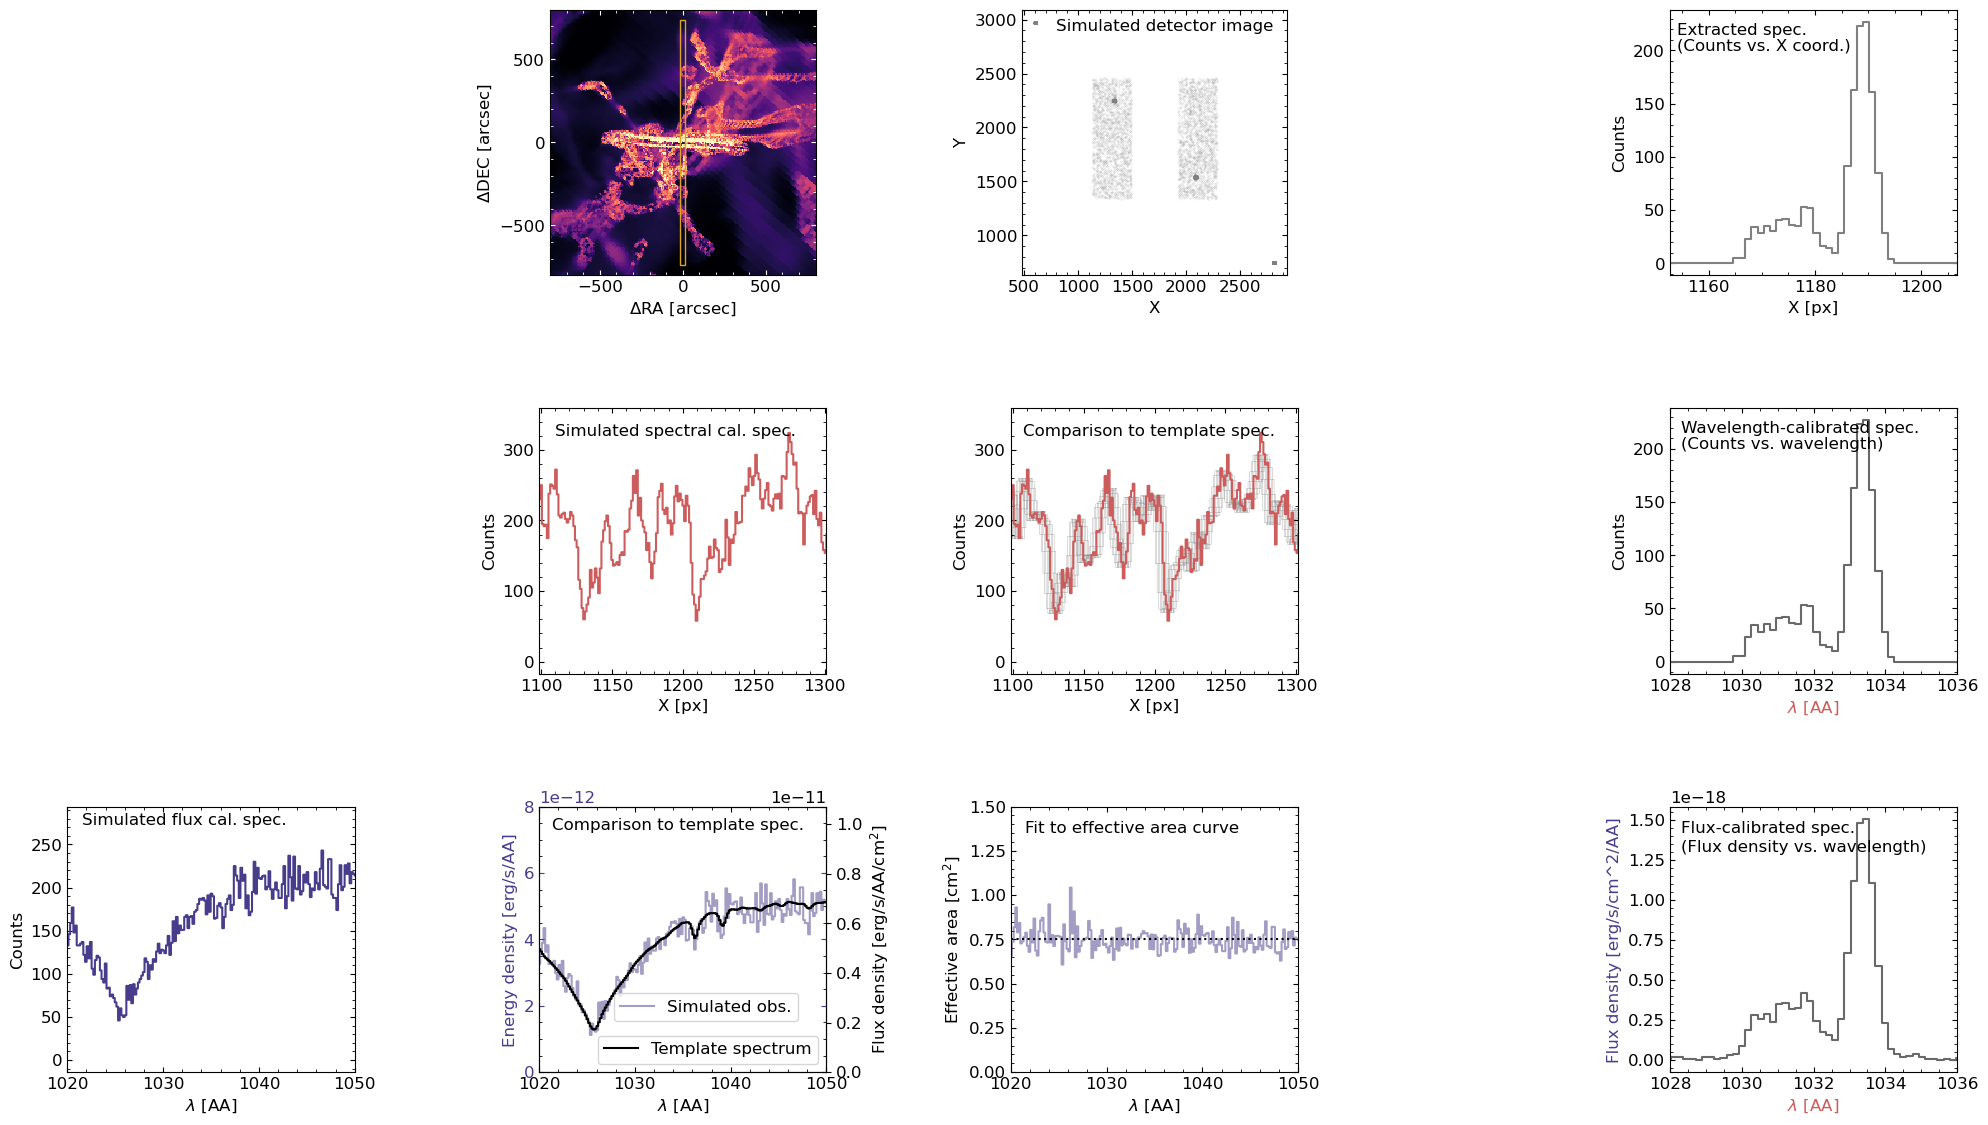

In [78]:
plotSpectralCalProcess()